# Solute transport in uniform background flow

AdePy provides several solutions for solute transport in groundwater with uniform background flow. These can be used to predict the fate of dissolved solutes in several common groundwater contamination settings.

In [1]:
# imports used across the examples
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Assumptions and limitations

Following assumptions are made for all available solutions in AdePy, unless stated otherwise:

 - The algorithms are solutions to the advection-dispersion equation describing Fickian solute transport for a single dissolved species in a saturated porous medium. The species may be subjected to linear equilibrium sorption and first-order decay. 
 - The aquifer consists of a single layer, with a single (mobile) domain. Mobile-immobile transfers are not incorporated in the solutions. The 1D `mpne()` solution is the exception to this.
 - The aquifer's transport and reaction parameters are assumed constant in time and space.
 - Only the dissolved and sorbed solid phase are simulated.
 - No density- or viscocity-dependent flow is available. Note that for large concentrations, density effects may occur in the field but can not be simulated with AdePy.
 - The groundwater flow in the system is steady, uniform and in the direction of the increasing x-axis. No aquifer has a truly uniform (or steady) flow regime, but in some cases, the flow around the area of interest may be approximated as uniform. This assumption also implies that point source injection rates are limited so that the flow field remains uniform. Additionally, pump-and-treat systems where large pumping rates are present can not be simulated, as they would violate the assumption of uniform flow. Lastly, and perhaps less evident, the effects of clean areal recharge pushing a contamination plume downwards in a phreatic aquifer over long time periods can not be simulated directly.
 - Expect for the source term for each solution, no other sinks or sources are available, although multiple solutions can be superimposed to create complex source geometries. This means that no sinks are available that remove mass at the ambient aquifer concentrations, e.g. sinks in the flow system such as rivers.

Despite these limitations, analytical solutions can be useful tools, as they are fast and easy to use, free of numerical artefacts that plague numerical transport models, and -most importantly- provide valuable insight into solute transport problems in groundwater, which otherwise need to be obtained from expensive, complex and data-intensive numerical models.



## 1D, 2D or 3D solutions

Solutions for 1D, 2D and 3D transport in uniform background flow are available from the `adepy.uniform.oneD`, `adepy.uniform.twoD` and `adepy.uniform.threeD` modules, respectively. In 1D transport, the contaminant can only spread along a single dimension, in the direction of flow. This may be valid for column experiments or along streamlines of particles with constant velocity, such as plume centerlines of vertical percolation pathways. In 2D transport, spreading occurs along two dimensions, as can be the case for thin aquifers or aquifers where the plume is well-mixed along the vertical axis. Alternatively, 2D solutions may be used for transport simulations along an aquifer cross-section, where the second model dimension then represents the real-world vertical axis. In doing so, it is assumed that solute spreading perpendicular to the cross-section is negligible. Lastly, 3D solutions simulate solute spreading along all three Cartesian spatial coordinate axes.

Care must be taken when selecting the correct dimensionality of the system, as significant errors may occur when this is misjudged [(Zhen & Bennet, 2002)](https://qa.store.wiley.com/en-no/Applied+Contaminant+Transport+Modeling%2C+2nd+Edition-p-9780471384779). As the example below shows, approximating a 3D problem with a 2D or 1D solution (or vice versa) will lead to errors in the predicated concentration. As the dimensionality of the spreading increases, the concentration decreases since the solute can dilute more along the extra dimension(s).

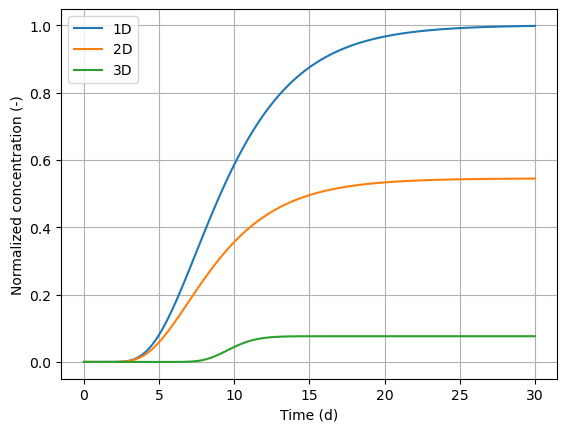

In [2]:
from adepy.uniform import patchi, stripi, seminf1

v = 1  # average linear groundwater flow velocity in the x-direction, m/d
al = 1 # longitudinal dispersivity, m
ah = 0.1 # horizontal transverse dispersivity, m
av = 0.01 # vertical transverse dispersivity, m
c0 = 1 # source concentration, mg/L

# source geometry
y1 = -1 # lower y-coordinate of source, m
y2 = 1 # upper y-coordinate of source, m
z1 = -0.25 # lower z-coordinate of source, m
z2 = 0.25 # upper z-coordinate of source, m

# observation point
x = 10 # x-coordinate of observation well, m
y = 0 # y-coordinate of observation well, m
z = 0 # z-coordinate of observation well, m

t = np.linspace(0.01, 30, 100) # output times, d

# 1D solution
c1d = seminf1(c0, x, t, v, al)

# 2D solution
c2d = stripi(c0, x, y, t, v, al, ah, y1, y2)

# 3D solution
c3d = patchi(c0, x, y, z, t, v, ah, al, av, y1, y2, z1, z2)

# plot
plt.plot(t, c1d / c0, label="1D")
plt.plot(t, c2d / c0, label="2D")
plt.plot(t, c3d / c0, label="3D")

plt.xlabel("Time (d)")
plt.ylabel("Normalized concentration (-)")
plt.grid()
plt.legend()

## Initial conditions

For the conservative solutes, initial conditions can be specified by adding a constant background concentrations to the model results. For reactive species, initial conditions are assumed zero.

Often, the geometry, magnitude and release history of a contaminant source are unknown. In those cases, the current plume as measured in the field may be used as initial concentrations to simulate the transport in the aquifer, assuming the source is removed. From this initial plume configuration, the resulting concentration field after a certain time may be calculated. The `plume1()`, `plume2()` and `plume3()` methods simulate the fate of an initial mass field in 1, 2 and 3 dimensions, respectively. The initial mass $M_0$ at a certain location can be calculated from an initial concentration $C_0$ as $M_0 = C_0  V  n$ with $V$ the bulk volume of the corresponding aquifer over which the concentration is thought to be representative, and $n$ the aquifer porosity. If $C_0$ is available on a grid, e.g. as output of a previous model run, the grid spacing can be used to calculate $V$.

This is illustrated below by using a predefined 2D concentration field on a regular $100~x~100~m$ grid to compute the initial mass configuration, and simulating the fate of this plume using `plume2()`. The initial concentration field is based on [the MODFLOW 6 example problem 45](https://modflow6-examples.readthedocs.io/en/master/_examples/ex-gwt-mt3dms-p09.html).


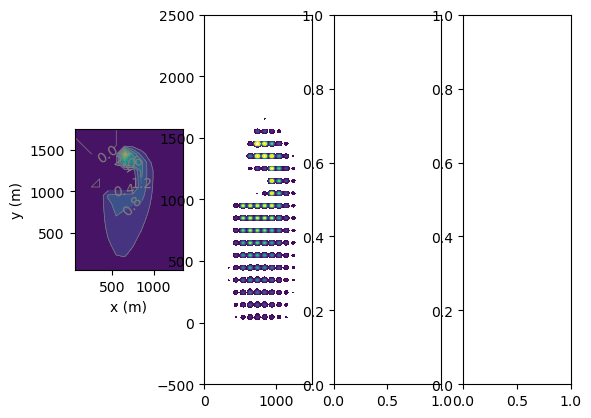

In [3]:
from adepy.uniform.twoD import plume2

# load predefined concentration grid and convert to mass
c0 = np.loadtxt('../data/c0.txt')

# recreate initial concentration grid
dx = 100 # grid x-spacing of predefined concentration field, m
dy = 100 # grid y-spacing of predefined concentration field, m
xg, yg = np.meshgrid(np.arange(50, 1351, dx), np.arange(1751, 50, -dy))

# aquifer parameters
v = 0.05 # average linear groundwater flow velocity in the x-direction, m
n = 0.25 # aquifer porosity, -
al = 2 # longitudinal dispersivity, m
ah = 0.2 # horizontal transverse dispersivity, m

t = np.array([5, 10, 15]) * 365 # output times, d

# calculate initial mass field, ppm
m0 = c0 * dx * dy * n

# calculate the concentration field on a new grid, assuming the source is removed
x, y = np.meshgrid(np.linspace(0, 1500, 150), np.linspace(-500, 2500, 150))
cn = []
for ti in t:
    cn.append(
        plume2(m0, x, y, ti, v, n, al, ah, xc=xg, yc=yg)
    )

# plot
fig, ax = plt.subplots(1, 4)
lvls = np.arange(0.2, 10, 0.4)
ax[0].contourf(xg, yg, c0, levels=10)
cf = ax[0].contour(xg, yg, c0, levels=10, colors='grey', linewidths=0.5)
ax[0].clabel(cf)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')

ax[1].contourf(x, y, cn[0], levels=lvls)


<a list of 34 text.Text objects>

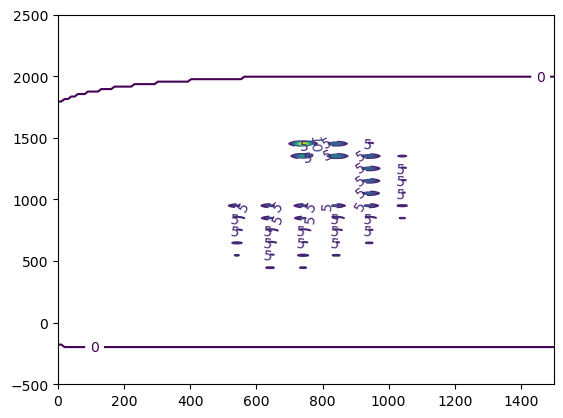

In [4]:
cf=plt.contour(x, y, cn[0], levels=10)
plt.clabel(cf)

## Superposition

Since all equations provided by AdePy are linear, the superposition principle can be applied whereby results can be superimposed in space and time. This allows the creation of complex source geometries and release timings.

### In space

To superimpose solutions in space for a given output time `t`, simply add the corresponding results at the requested locations. This is illustrated here using the example shown by [Wexler (1992)](https://doi.org/10.3133/twri03B7) in their Figure 2B-C. There, a waste-disposal site has spatially varying-input concentrations of a conservative solute (subplot B). The resulting input concentration distribution along `x=0` is shown in subplot C. 

The 2D solution `stripi()` is used to simulate the contaminant plume. Two models are made with differing source concentrations ($250~mg/L$ and $600~mg/L$), and a background concentration of $50~mg/L$ is added to the results.

<div>
<img src="../_figs/wexler_fig2B-C.png" width="75%" />
</div>


Text(0, 0.5, 'y (ft)')

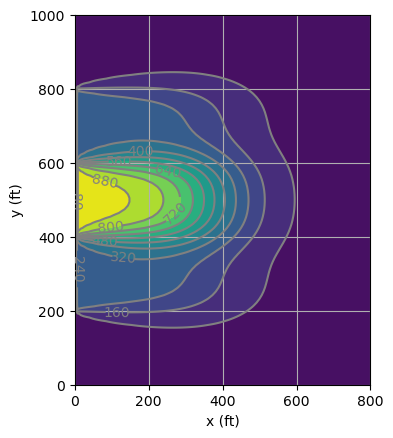

In [5]:
from adepy.uniform.twoD import stripi

v = 1.0  # linear groundwater flow velocity, ft/d
al = 20.0  # longitudinal dispersivity, m
ah = 4.0  # horizontal transverse dispersivity, m

t = 365  # output time, d
x, y = np.meshgrid(np.linspace(0, 800, 100), np.linspace(0, 1000, 100))

# source terms
cbackground = 50.0  # background concentration, mg/L

c1 = 250  # input concentration of the first source, mg/L
y0 = 200  # lower y-coordinate of the first source, ft
y1 = 800  # upper y-coordinate of the first source, ft

c2 = 600  # input concentration of the second source, mg/L
y2 = 400  # lower y-coordinate of the second source, ft
y3 = 600  # upper y-coordinate of the second source, ft

cA = stripi(c1, x, y, t, v, al, ah, y0, y1)
cB = stripi(c2, x, y, t, v, al, ah, y2, y3)

# superimpose
c = cA + cB + cbackground

plt.contourf(x, y, c, levels=10)
ca = plt.contour(x, y, c, levels=10, colors="grey")
plt.clabel(ca)
plt.gca().set_aspect("equal")
plt.grid()
plt.xlabel("x (ft)")
plt.ylabel("y (ft)")

### In time

Superposition in time can be applied to simulate time-varying source loading. This is achieved by first simulating the concentration field up until a requested output time, and then adding the results from a second simulation which starts at the time when the input has changed and has an input concentration equal to the difference between the old and new source concentration. The general formula is as follows:

$$
C_t = C_b + F(c_0, t - t_0) + \sum^N_{i=1}{F(c_i - c_{i-1}, t - t_i)}
$$

with $C_t$ $[M/L^3]$ the concentration at the requested output time $t$ $[T]$, $C_b$ a background concentration for conservative solutes $[M/L^3]$, $F$ a model to simulate solute transport based on a source concentration and an output time, $c_i$ the source concentration for the $i^{th}$ source signal $[M/L^3]$, $t_i$ the start time of the $i^{th}$ source signal and $N$ the number of source signals.

This is illustrated in the example below for a continuous point source with three leaching stages. The initial leaching starts at time `t=0`. At time `t1` the concentration of the leachate increases. At time `t2` the source is removed by setting the source concentration to zero. The source simulates three dimensional solute spreading and the breakthrough curve is observed at a well some distance downgradient.

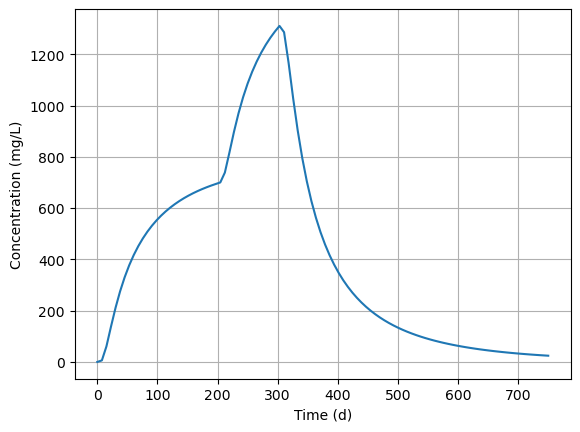

In [6]:
# Example for BTC with point3
from adepy.uniform import point3

v = 0.05  # linear groundwater flow velocity in the x-direction, m/d
n = 0.2  # aquifer porosity, -
al = 4  # longitudinal dispersivity, m
ah = 1  # horizontal transverse dispersivity, m
av = 1  # vertical transverse dispersivity, m

c0 = [500, 1000, 0]  # injection concentrations, mg/L
t0 = [0, 200, 300]  # start of leaching stages, d
xc = 0  # source x-location, m
yc = 0  # source y-location, m
zc = 0  # source z-location, m
Q = 1.0  # volumetric injection rate, m^3/d

x = 5  # output x-location, m
y = 0  # output y-location, m
z = 0  # output z-location, m
t = np.linspace(0.001, 750, 100)  # output times, d

# first leaching stage
c = point3(c0[0], x, y, z, t - t0[0], v, n, al, ah, av, Q, xc, yc, zc)

# second leaching stage
c[t > t0[1]] += point3(
    c0[1] - c0[0], x, y, z, t[t > t0[1]] - t0[1], v, n, al, ah, av, Q, xc, yc, zc
)

# third leaching stage, source is removed
c[t > t0[2]] += point3(
    c0[2] - c0[1], x, y, z, t[t > t0[2]] - t0[2], v, n, al, ah, av, Q, xc, yc, zc
)

plt.plot(t, c)
plt.xlabel("Time (d)")
plt.ylabel("Concentration (mg/L)")
plt.grid()

## Source decay

The source concentration argument `c0` in the functions from `adepy.uniform` is only used as a scaling parameter for the underlying solution. This is also the case for the injection rate used in the point-source algorithms. As such, the `c0` argument in the function call can be replaced by unity and calculated unit concentration field can be scaled outside the function by an arbitrary value or array. In doing so, a non-constant source concentration can be used. For example, first-order decay can be applied to the source concentration as well, using:

$$
C_{0,t} = C_{0,0}e^{-\lambda_s t}
$$

with $C_{0,t}$ the source concentration $[M/L^3]$ at time $t$ $[T]$, $C_{0,0}$ the initial source concentration $[M/L^3]$ at time $t=0$ and $\lambda_s$ the first-order decay rate of the source term $[T^{-1}]$. This is illustrated in the following example:

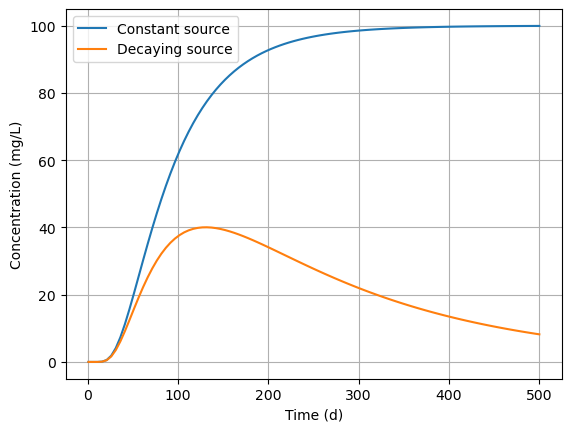

In [7]:
from adepy.uniform import seminf1

c0 = 100  # initial source concentration, mg/L
lamb_s = 0.005  # first-order source decay rate, 1/d
v = 0.05  # groundwater flow, m/d
al = 1  # longitudinal dispersivity, m

x = 5.0  # output x-coordinate, m
t = np.linspace(1, 500, 100)  # output times, d

# calculate and plt concentrations for a constant source term and a decaying source term
c_constant = seminf1(c0=c0, x=x, t=t, v=v, al=al)
c_decay = c0 * np.exp(-lamb_s * t) * seminf1(c0=1.0, x=x, t=t, v=v, al=al)

plt.plot(t, c_constant, label="Constant source")
plt.plot(t, c_decay, label="Decaying source")
plt.xlabel("Time (d)")
plt.ylabel("Concentration (mg/L)")
plt.grid()
plt.legend()

## Chemical reactions

The effects of geochemical reactions can be incorporated in the models through the retardation coefficient `R` and the first-order decay constant `lamb`. These parameters are input for all models in AdePy and default to 1.0 and 0.0 respectively, i.e. no retardation effects or first-order decay.

With the exception of the 1D `mpne()` solution, the description of available chemical reactions below applies to all solutions in AdePy.

### Linear equilibrium adsorption

Linear equilibrium adsorption can be expressed through the dimensionless retardation coefficient $R$ following:

$$
R = 1 + \frac{\rho_b  K_d}{\theta}
$$

and

$$
K_d = \frac{\partial \bar{C}}{\partial C}
$$

with $\rho_b$ the dry bulk density of the porous medium $[M/L^3]$, $K_d$ the linear adsorption isotherm or 'distribution coefficient' $[L^3/M]$, expressing the rate of change in sorbed concentration $\bar{C}$ $[M/M]$ per change in aqueous concentration $C$ $[M/L^3]$ and $\theta$ the porosity $[-]$. The adsorption process is reversible, allowing for desorption to occur.

AdePy only simulates aqueous concentrations. To obtain the sorbed concentration through linear equilibrium sorption at given location and time, use the relation above. This is illustrated in the example below for 1D solute transport with and without linear equilibrium sorption with a constant concentration boundary at the inlet. The source is active for 2 hours, after which solute-free water is passed through the system. The principle of superposition is applied to obtain the resulting concentrations.

R = 1.24


Text(0, 0.5, 'Concentration (mg/lb)')

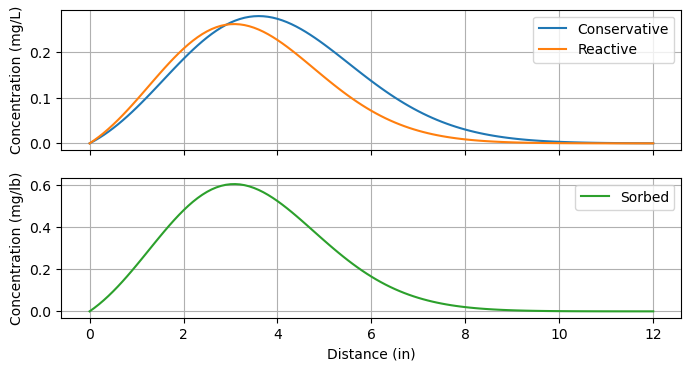

In [8]:
from adepy.uniform.oneD import seminf1

v = 0.6  # linear groundwater flow velocity, in/h
al = 1  # longitudinal dispersivity, in
c0 = 1.0  # inlet constant concentration, mg/L

rho_b = 0.047  # dry bulk density, lb/in³
kd = 2.3  # linear adsorption distribution coefficient, in³/lb
n = 0.45  # porosity, -

# Calculate the retardation coefficient
R = 1 + kd * rho_b / n
print(f"R = {R:.2f}")

x = np.arange(0, 12.1, 0.1)  # in
t = 5  # output time, h
t0 = 2  # source duration, h

# simulate for a conservative and reactive solute
ccons = seminf1(c0, x, t, v, al, R=1.0) + seminf1(-c0, x, t - t0, v, al, R=1.0)
creact = seminf1(c0, x, t, v, al, R=R) + seminf1(-c0, x, t - t0, v, al, R=R)

# calculate sorbed concentration in [M/M], assuming initial aqueous and sorbed concentrations are zero
csorbed = creact * kd

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
ax[0].plot(x, ccons, label="Conservative")
ax[0].plot(x, creact, label="Reactive")
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("Concentration (mg/L)")

ax[1].plot(x, csorbed, label="Sorbed", color="C2")
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel("Distance (in)")
ax[1].set_ylabel("Concentration (mg/lb)")

### Ion exchange

Ion exchange can be simulated through the use of the retardation coefficient $R$, by assuming that the counter ion $B^+$ is present in concentrations much larger than the simulated species $A^+$, such that its concentration can be assumed constant, and that all exchange sites are initially occupied by $B^+$. Then, the linear equilibrium distribution coefficient $K_d$ is:

$$
K_d = \frac{K_sCEC}{[B^+]}
$$

or for the case of a divalent solute species $A^{++}$:

$$
K_d = \frac{K_sCEC^2}{[B^+]^2}
$$

with $K_s$ the equilibrium exchange coefficient $[-]$, $CEC$ the cation exchange capacity $[M/M]$, and $[B^+]$ the aqueous concentration of the monovalent counter ion $B$. The resulting $K_d$ value can then be used to calculate the retardation coefficient $R$ as discussed above.


### First-order decay

Species subjected to irreversible first-order radioactive decay or production, or first-order biological degradation can be simulated using the `lamb` coefficient which represents the species' decay rate $\lambda$ $[1/T]$. If sorption is also simulated, and the sorbed phase should not be subjected to  first-order decay, the decay rate $\lambda$ should be replaced by $\lambda/R$ with $R$ the retardation coefficient.


### Parent-daughter chain reactions

AdePy supports the simulation of multi-species parent-daught chain decay in parallel or series, where a parent species decays into a daughter species through a first-order process, as is the case for the transformation of chlorinated hydrocarbons. The transformation method of [Sun & Clement (1999)](https://doi.org/10.1023/A:1006507514019) is used, which allows any of the available AdePy algorithms to be used as the transport solution. A restriction of this method however, is that all involved species should have the same retardation coefficient for the results to be sensible. 

The 1D and 2D examples below show the use of the `chain_reaction()` method, which takes as input the first-order decay rates of each parent-daughter combination, the corresponding stiochiometric production coefficients (note that for species without a parent, these should be set to zero), and a dictionary describing the parent-daughter species indices as `{species: parent}` with `species` and `parent` each an integer species index. For the 1D example, the `seminf1()` solution is used to describe transport. In the 2D example, `point2()` is used for the same reaction chain. Additional input for these functions are passed to `chain_reaction()` as keyword arguments. The output is a list with the simulated concentration for each species, subjected to first-order chain decay.

In [9]:
from adepy import chain_reaction

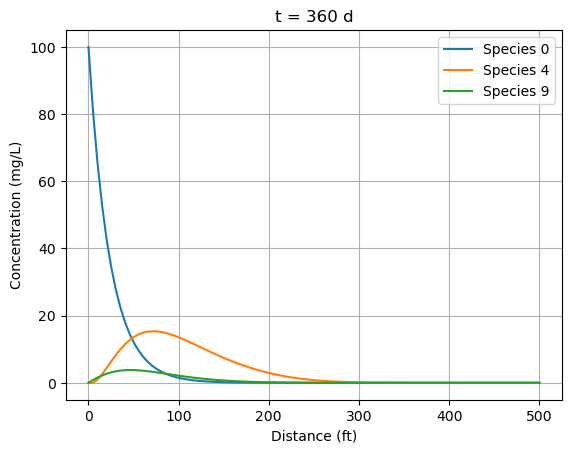

In [10]:
# 1D example ----
from adepy.uniform import seminf1

# set first-order decay rates, stoichiometric coefficients and ancestry dict
lamb = [0.03, 0.02, 0.015, 0.01, 0.011, 0.006, 0.002, 0.0015, 0.003, 0.002]
stoi = [
    0,
    0.79,
    0.50,
    0.45,
    0.74,
    0.64,
    0.37,
    0.51,
    0.51,
    0.45,
]  # first value is zero here, as species 0 has no parent
ancestry = {
    0: -1,  # species: parent, -1 for no parent
    1: 0,
    2: 1,
    3: 2,
    4: 1,
    5: 4,
    6: 2,
    7: 6,
    8: 3,
    9: 5,
}

v = 0.5  # uniform groundwater flow velocity, ft/d
al = 10  # longitudinal dispersivity, ft

x = np.linspace(0, 500, 100)  # output coordinates, ft
t = 360  # output time, d

# source concentrations for all species: all are zero except for the first species
c0 = np.zeros(len(lamb))
c0[0] = 100.0  # mg/L

# calculate the chain reactions using the seminf1() solution for transport
c = chain_reaction(ancestry, lamb, stoi, c0, seminf1, x=x, t=t, al=al, v=v)

fig, ax = plt.subplots(1, 1)
for i in [0, 4, 9]:
    ax.plot(x, c[i], label=f"Species {i}")

ax.set_xlabel("Distance (ft)")
ax.set_ylabel("Concentration (mg/L)")
ax.set_title(f"t = {t} d")
ax.grid()
ax.legend()

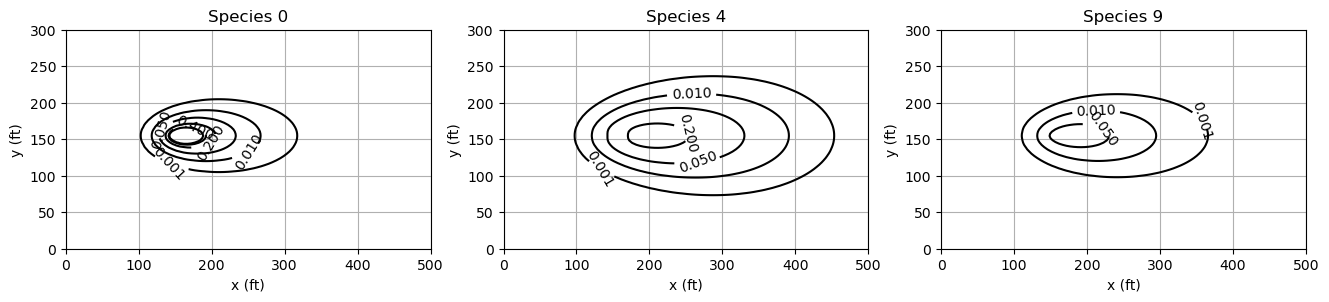

In [11]:
# 2D example ----
from adepy.uniform import point2

ah = 3  # horizontal transverse dispersivity, ft
n = 0.2  # aquifer porosity, -
xc = 155  # point source x-location, ft
yc = 155  # point source y-location, ft
Qa = 1 / 10  # point source injection rate per unit aquifer thickness, ft**2/d

# output grid
x, y = np.meshgrid(np.linspace(0, 500, 100), np.linspace(0, 300, 100))

# calculate chain reaction concentrations
# again, only the first parent species has a non-zero source concentration
c = chain_reaction(
    ancestry,
    lamb,
    stoi,
    c0,
    point2,
    x=x,
    y=y,
    t=t,
    v=v,
    n=n,
    al=al,
    ah=ah,
    Qa=Qa,
    xc=xc,
    yc=yc,
)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
for i, id in enumerate([0, 4, 9]):
    cs = ax[i].contour(
        x, y, c[id], colors="black", levels=[0.001, 0.01, 0.05, 0.2, 0.4, 0.5]
    )
    plt.clabel(cs)
    ax[i].set_xlabel("x (ft)")
    ax[i].set_ylabel("y (ft)")
    ax[i].grid()
    ax[i].set_title(f"Species {id}")
    ax[i].set_aspect("equal")

## Angled flow

The solutions for transport in uniform flow assume that flow is in the direction of the x-axis. The user must reproject the output to align with the real-world flow direction. For point sources however, a simple transformation calculation can be applied to rotate the flow in the model domain. This is useful if the direction of flow is not well known. Note that this transformation can also be used for non-point sources, but artefacts may occur at the unrotated `x=0` location, where the source is located.

To rotate the flow in the horizontal plane, the output coordinates, as well as the source location, can be transformed using:

\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} \cos\alpha & \sin\alpha \\ -\sin\alpha & \cos\alpha \end{bmatrix}\begin{bmatrix} x \\ y \end{bmatrix}

with $x'$ and $y'$ the rotated x and y coordinates, and $\alpha$ the angle of rotation, in radians.

The example below simulates the fate of a 3D plume from a point source in uniform background flow towards the northeast. Compare this to the same example with uniform flow in the x-direction as shown on the [README file](https://github.com/cneyens/adepy/tree/main/README.md).

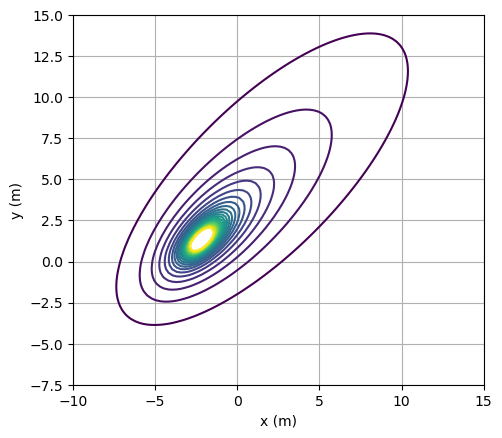

In [12]:
from adepy.uniform.threeD import point3

xc = -2.2  # x-coordinate of point source, m
yc = 1.3  # y-coordinate of point source, m
zc = 0  # z-coordinate of point source, m
c0 = 100  # injection concentration, mg/L
Q = 1  # injection rate, m³/d

angle = 45.0  # angle of flow, degrees counterclockwise from the positive x-axis
v = 0.05  # uniform groundwater flow velocity in x-direction, m/d
al = 5  # longitudinal dispersivity, m
ah = 1  # horizontal transverse dispersivity, m
av = 0.1  # vertical transverse dispersivity, m
n = 0.2  # porosity, -

t = 365  # output time, d
x, y = np.meshgrid(
    np.linspace(-10, 15, 100), np.linspace(-7.5, 15, 100)
)  # output grid x-y coordinates, m
z = 0  # output grid z-coordinate, m

# calculate rotation matrix
alpha = angle * np.pi / 180.0  # to radians
transf_array = np.array(
    [[np.cos(alpha), np.sin(alpha)], [-np.sin(alpha), np.sin(alpha)]]
)

# transform the source locations
locT = transf_array.dot(np.array([xc, yc]).T)
xcT = locT[0]
ycT = locT[1]

# transform the output grid and reshape
locG = transf_array.dot(np.vstack([x.flatten(), y.flatten()]))
xgT = locG[0, :].reshape(x.shape)
ygT = locG[1, :].reshape(y.shape)

# simulate on the rotated grid with the rotated source location
c = point3(c0, xgT, ygT, z, t, v, n, al, ah, av, Q, xcT, ycT, zc)

# note that for the plot, the unrotated x-y locations are used
plt.contour(x, y, c, levels=np.arange(100, 2501, 100))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.gca().set_aspect("equal")
plt.grid()

## Heat transport

Heat transport in groundwater is analogous to solute transport in groundwater. By adjusting the transport parameters and assuming the transport species is temperature $T$ $[\Theta]$, a transport equation can be used to simulate heat transport, including convection, conduction and thermal equilibrium between the groundwater and the aquifer material. These are analogous to advection and mechanical dispersion, molecular diffusion and linear equilibrium sorption for solute transport, respectively.

Following parameter conversions are needed (Zheng, 2010):

$$
\begin{aligned}
    k_0 &= n k_w + (1 - n) k_s  \\
    D_m &= \frac{k_0}{n  \rho_w  C_w} \\ 
    \rho_b &= (1 - n) \rho_s  \\
    K_d &= \frac{C_s}{C_w \rho_w}  \\
    R &= 1 + \frac{K_d \rho_b}{n}  \\
\end{aligned}
$$

with $k_0$ the bulk thermal conductivity of the aquifer $[\frac{E}{TL\Theta}]$, $k_w$ the thermal conductivity of the groundwater $[\frac{E}{TL\Theta}]$, $k_s$ the thermal conductivity of the aquifer material $[\frac{E}{TL\Theta}]$, $n$ the aquifer porosity $[-]$, $D_m$ the effective molecular diffusion coefficient $[L^2/T]$, $\rho_w$ the density of the groundwater $[M/L^3]$, $C_w$ the specific heat capacity of the groundwater $[\frac{E}{M\Theta}]$, $\rho_b$ the dry bulk density of the aquifer $[M/L^3]$, $\rho_s$ the density of the solid aquifer material $[M/L^3]$, $K_d$ the linear equilibrium distribution coefficient $[L^3/M]$, $C_s$ the specific heat capacity of the aquifer material $[\frac{E}{M\Theta}]$ and $R$ the retardation coefficient $[-]$.

For point injections of energy, setting the injection rates to unity:

$$
\begin{aligned}
    Q &= 1 \\
    C_0 &= \frac{F_0}{\rho_w C_w} \\
\end{aligned}
$$

with $Q$ the point injection rate or infiltration flux, $C_0$ the injection concentration $[M/L^3]$, and $F_0$ the heat injection rate $[E/T]$.

In the example below, the effect of 365 days of continuous heat extraction through a Borehole Heat Exchanger (BHE) in an infinite aquifer with uniform background flow is simulated. The aquifer has an initial background concentration of $12~°C$. The BHE is screened across the entire aquifer thickness and heat injection is evenly distributed along the borehole length, rendering the solute transport two-dimensional. The borehole radius is assummed negligibly small, so that the `point2()` algorithm can be used to simulate the heat transport. Mechanical dispersion is neglected in this example.

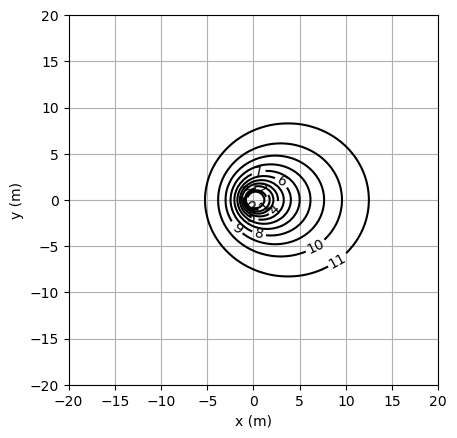

In [13]:
from adepy.uniform.twoD import point2

v = 0.05 / 86400  # uniform groundwater flow velocity, m/s
n = 0.25  # aquifer porosity, -
al = 0  # longitudinal dispersivity, m
ah = 0  # horizontal transverse dispersivity, m
T0 = 12  # ambient groundwater temperature, °C

# heat transport parameters
kw = 0.59  # thermal conductivity of groundwater, W/m/°C
ks = 2.5  # thermal conductivity of aquifer material, W/m/°C
rho_w = 1000  # density of groundwater, kg/m^3
rho_s = 2650  # density of solid aquifer material, kg/m^3
cs = 900  # specific heat capacity of solid aquifer material, J/kg/°C
cw = 4184  # specific heat capacity of groundwater, J/kg/°C

# calculate equivalent transport parameters
k0 = n * kw + (1 - n) * ks  # bulk thermal conductivity of aquifer, W/m/°C
rho_b = (1 - n) * rho_s  # bulk density of aquifer, kg/m^3
Dm = k0 / (n * rho_w * cw)  # effective molecular diffusion coefficient, m^2/s
Kd = cs / (cw * rho_w)  # linear distribution coefficient, m^3/kg
R = 1 + Kd * rho_b / n  # retardation coefficient, -

# source term
F0 = -80.0  # heat extraction rate per unit aquifer thickness, W/m
Qa = 1.0  # unity injection rate
c0 = F0 / (rho_w * cw)  # injection concentration, mg/L
xc = 0.0  # BHE x-location, m
yc = 0.0  # BHE y-location, m

t = 365 * 86400  # output time, s
x, y = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100))

T = T0 + point2(c0, x, y, t, v, n, al, ah, Qa, xc, yc, Dm, R=R)

# plot temperature contours after 1 year
ca = plt.contour(x, y, T, levels=np.arange(0, T0 + 1, 1), colors="black")
plt.clabel(ca)
plt.gca().set_aspect("equal")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()

Text(0, 0.5, 'Temperature (°C)')

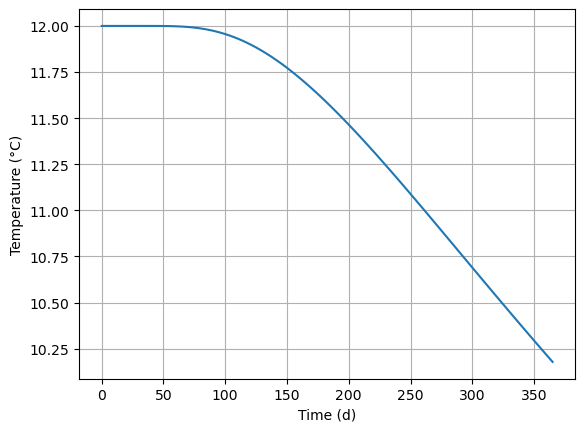

In [14]:
# plot temperature breakthrough curve at observation point downgradient
xobs = 10
yobs = 0
tobs = np.linspace(1, t, 100)
Tobs = T0 + point2(c0, xobs, yobs, tobs, v, n, al, ah, Qa, xc, yc, Dm, R=R)

plt.plot(tobs / 86400, Tobs)
plt.grid()
plt.xlabel("Time (d)")
plt.ylabel("Temperature (°C)")